# \Conjecture 1: Is E[w_tilde] an Unbiased Estimator of w*?

We sample M independent training sets of size n, compute the max-margin
direction w_tilde_m for each, and check whether their average converges
in direction to w*/||w*||.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import norm
from model import OverparameterizedLogisticRegression

In [2]:
def collect_wtildes(M, d=2000, n=1000, k=100, seed_offset=0):
    """Sample M independent datasets and compute w_tilde for each.

    Returns:
        wtildes: array of shape (M, d), each row is a w_tilde_m
        w_star_dir: normalized w* direction
    """
    wtildes = []
    w_star_dir = None

    for m in range(M):
        model = OverparameterizedLogisticRegression(
            d=d, n=n, k=k, seed=seed_offset + m
        )
        model.generate_data()
        model.compute_max_margin_direction()
        wtildes.append(model.w_tilde.copy())

        if w_star_dir is None:
            w_star_dir = model.w_star / norm(model.w_star)

        if (m + 1) % 5 == 0 or m == 0:
            print(f'  Completed {m + 1}/{M} samples')

    return np.array(wtildes), w_star_dir

In [3]:
def plot_convergence_of_average(wtildes, w_star_dir):
    """Plot how cos(avg_wtilde, w*) evolves as we include more samples."""
    M = len(wtildes)
    cos_values = []
    for m in range(1, M + 1):
        avg = np.mean(wtildes[:m], axis=0)
        avg_dir = avg / norm(avg)
        cos_values.append(np.dot(avg_dir, w_star_dir))

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(range(1, M + 1), cos_values, linewidth=2)
    ax.set_xlabel('Number of samples M')
    ax.set_ylabel(r'$\cos(\mathrm{avg}(\tilde{w}_m),\; w^*/\|w^*\|)$')
    ax.set_title(r'Cosine similarity of average $\tilde{w}$ to $w^*$ as M grows')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(1, M)
    plt.tight_layout()
    plt.show()

    print(f'Final cos(avg_wtilde, w*) at M={M}: {cos_values[-1]:.6f}')

In [4]:
def plot_component_analysis(wtildes, w_star_dir, k=100):
    """Analyze the average w_tilde by component.

    Shows:
    - Average w_tilde components in the informative subspace (first k)
    - Average w_tilde components in the uninformative subspace (rest)
    - Comparison to w* direction
    """
    d = wtildes.shape[1]
    avg_wtilde = np.mean(wtildes, axis=0)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Plot 1: Informative components (first k)
    ax = axes[0]
    ax.bar(range(k), avg_wtilde[:k], alpha=0.7, label=r'avg $\tilde{w}$')
    ax.bar(range(k), w_star_dir[:k], alpha=0.3, color='red', label=r'$w^*/\|w^*\|$')
    ax.set_xlabel('Component index')
    ax.set_ylabel('Value')
    ax.set_title(f'Informative components (1 to {k})')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 2: Uninformative components (k+1 to d), show norm
    ax = axes[1]
    uninformative_norms_avg = norm(avg_wtilde[k:])
    informative_norms_avg = norm(avg_wtilde[:k])
    ax.bar(['Informative', 'Uninformative'],
           [informative_norms_avg, uninformative_norms_avg],
           color=['blue', 'orange'])
    ax.set_ylabel('L2 norm of avg w_tilde')
    ax.set_title('Energy in informative vs uninformative subspace')
    ax.grid(True, alpha=0.3)

    # Plot 3: Individual w_tilde cosine similarities with w*
    ax = axes[2]
    individual_cos = [np.dot(wt, w_star_dir) for wt in wtildes]
    ax.hist(individual_cos, bins=30, alpha=0.7, edgecolor='black')
    avg_dir = avg_wtilde / norm(avg_wtilde)
    ax.axvline(np.dot(avg_dir, w_star_dir), color='red', linewidth=2,
               linestyle='--', label=f'avg direction: {np.dot(avg_dir, w_star_dir):.4f}')
    ax.set_xlabel(r'$\cos(\tilde{w}_m, w^*/\|w^*\|)$')
    ax.set_ylabel('Count')
    ax.set_title(r'Distribution of individual $\cos(\tilde{w}_m, w^*)$')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f'Norm of avg w_tilde in informative subspace: {informative_norms_avg:.6f}')
    print(f'Norm of avg w_tilde in uninformative subspace: {uninformative_norms_avg:.6f}')
    print(f'Mean individual cos(w_tilde_m, w*): {np.mean(individual_cos):.6f}')
    print(f'Std individual cos(w_tilde_m, w*): {np.std(individual_cos):.6f}')

In [5]:
def plot_directional_comparison(wtildes, w_star_dir, k=100):
    """Check if avg w_tilde direction matches w* direction within the informative subspace."""
    avg_wtilde = np.mean(wtildes, axis=0)

    # Restrict to informative subspace and normalize
    avg_informative = avg_wtilde[:k]
    avg_informative_dir = avg_informative / norm(avg_informative)
    wstar_informative_dir = w_star_dir[:k] / norm(w_star_dir[:k])

    cos_in_subspace = np.dot(avg_informative_dir, wstar_informative_dir)

    fig, ax = plt.subplots(figsize=(12, 5))
    x = np.arange(k)
    width = 0.4
    ax.bar(x - width/2, avg_informative_dir, width, alpha=0.7,
           label=r'avg $\tilde{w}$ (informative, normalized)')
    ax.bar(x + width/2, wstar_informative_dir, width, alpha=0.7,
           color='red', label=r'$w^*/\|w^*\|$ (informative, normalized)')
    ax.set_xlabel('Component index')
    ax.set_ylabel('Normalized value')
    ax.set_title(f'Direction comparison in informative subspace (cos = {cos_in_subspace:.6f})')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f'Cosine similarity in informative subspace: {cos_in_subspace:.6f}')
    if cos_in_subspace > 0.99:
        print('-> avg w_tilde points in the same direction as w* within informative subspace')
    else:
        print('-> avg w_tilde does NOT align with w* within informative subspace')

## Run Experiment

In [6]:
M = 20  # number of independent samples (increase for more accurate results)
wtildes, w_star_dir = collect_wtildes(M)

Parameters: d=2000, n=1000, k=100
tr(Sigma) = 1.6444
eta (used) = 0.188748
Data generated: X shape = (1000, 2000), y shape = (1000,)
Label balance: 46.90% positive
Max-margin SVM solved. Min margin = 0.999515
Support vectors (alpha > 1e-6): 607
  Completed 1/20 samples
Parameters: d=2000, n=1000, k=100
tr(Sigma) = 1.6444
eta (used) = 0.188748
Data generated: X shape = (1000, 2000), y shape = (1000,)
Label balance: 49.40% positive
Max-margin SVM solved. Min margin = 0.999788
Support vectors (alpha > 1e-6): 626
Parameters: d=2000, n=1000, k=100
tr(Sigma) = 1.6444
eta (used) = 0.188748
Data generated: X shape = (1000, 2000), y shape = (1000,)
Label balance: 48.30% positive
Max-margin SVM solved. Min margin = 0.999748
Support vectors (alpha > 1e-6): 625
Parameters: d=2000, n=1000, k=100
tr(Sigma) = 1.6444
eta (used) = 0.188748
Data generated: X shape = (1000, 2000), y shape = (1000,)
Label balance: 48.60% positive
Max-margin SVM solved. Min margin = 0.999503
Support vectors (alpha > 1e-6):

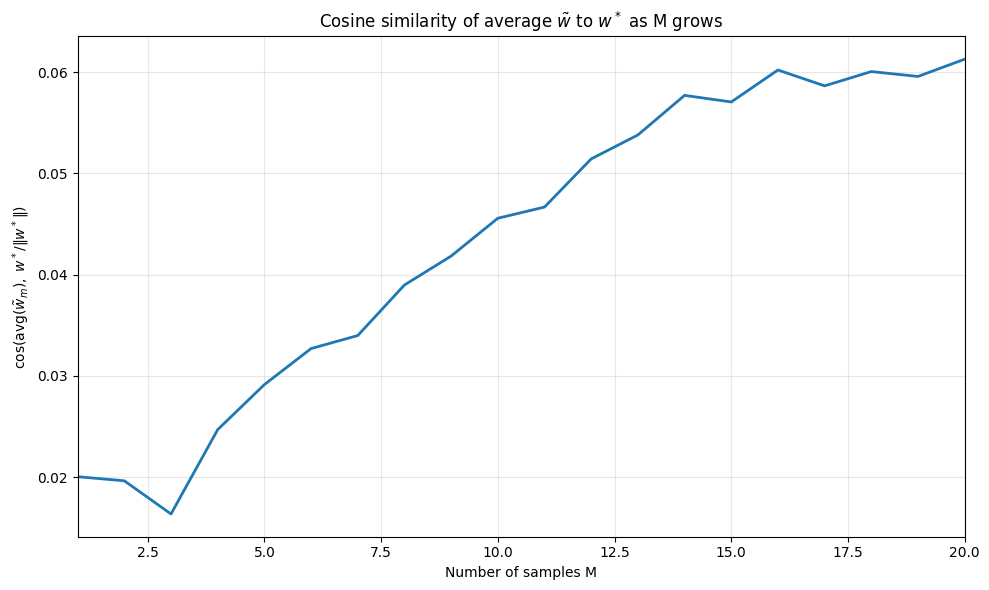

Final cos(avg_wtilde, w*) at M=20: 0.061290


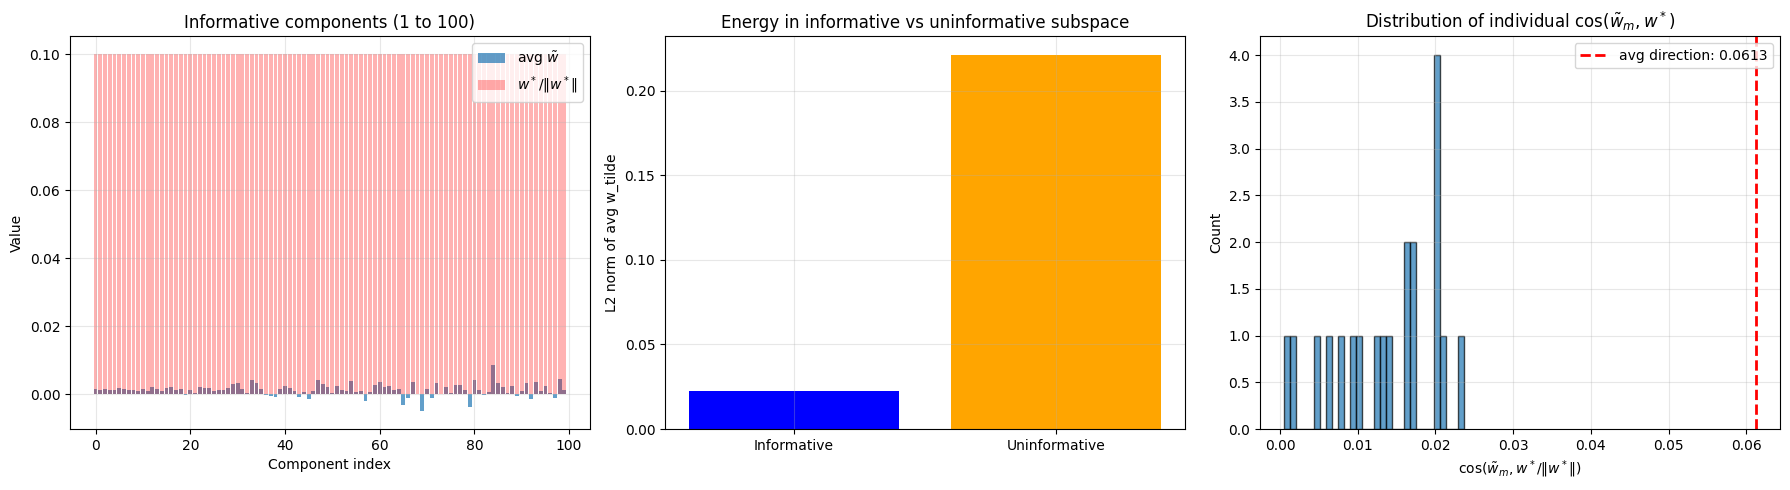

Norm of avg w_tilde in informative subspace: 0.022413
Norm of avg w_tilde in uninformative subspace: 0.220953
Mean individual cos(w_tilde_m, w*): 0.013612
Std individual cos(w_tilde_m, w*): 0.006636


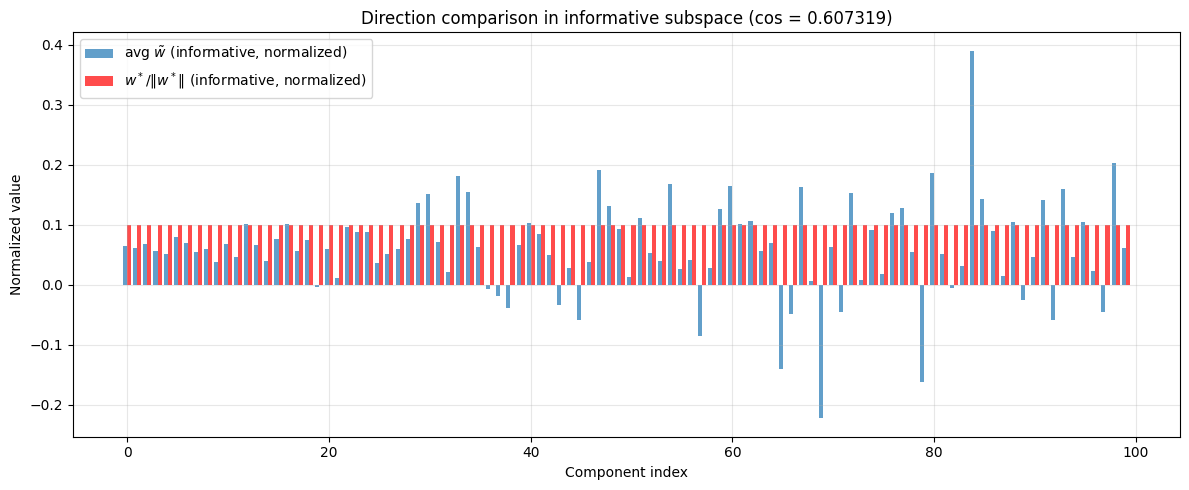

Cosine similarity in informative subspace: 0.607319
-> avg w_tilde does NOT align with w* within informative subspace


In [7]:
plot_convergence_of_average(wtildes, w_star_dir)
plot_component_analysis(wtildes, w_star_dir)
plot_directional_comparison(wtildes, w_star_dir)

## Increase M

To get more samples without recomputing, collect more and concatenate.

In [8]:
M_extra = 30
wtildes_extra, _ = collect_wtildes(M_extra, seed_offset=len(wtildes))
wtildes = np.concatenate([wtildes, wtildes_extra], axis=0)
print(f'Total samples: {len(wtildes)}')

Parameters: d=2000, n=1000, k=100
tr(Sigma) = 1.6444
eta (used) = 0.188748
Data generated: X shape = (1000, 2000), y shape = (1000,)
Label balance: 49.00% positive
Max-margin SVM solved. Min margin = 0.999647
Support vectors (alpha > 1e-6): 607
  Completed 1/30 samples
Parameters: d=2000, n=1000, k=100
tr(Sigma) = 1.6444
eta (used) = 0.188748
Data generated: X shape = (1000, 2000), y shape = (1000,)
Label balance: 47.50% positive
Max-margin SVM solved. Min margin = 0.999740
Support vectors (alpha > 1e-6): 617
Parameters: d=2000, n=1000, k=100
tr(Sigma) = 1.6444
eta (used) = 0.188748
Data generated: X shape = (1000, 2000), y shape = (1000,)
Label balance: 49.30% positive
Max-margin SVM solved. Min margin = 0.999842
Support vectors (alpha > 1e-6): 586
Parameters: d=2000, n=1000, k=100
tr(Sigma) = 1.6444
eta (used) = 0.188748
Data generated: X shape = (1000, 2000), y shape = (1000,)
Label balance: 50.20% positive
Max-margin SVM solved. Min margin = 0.999765
Support vectors (alpha > 1e-6):

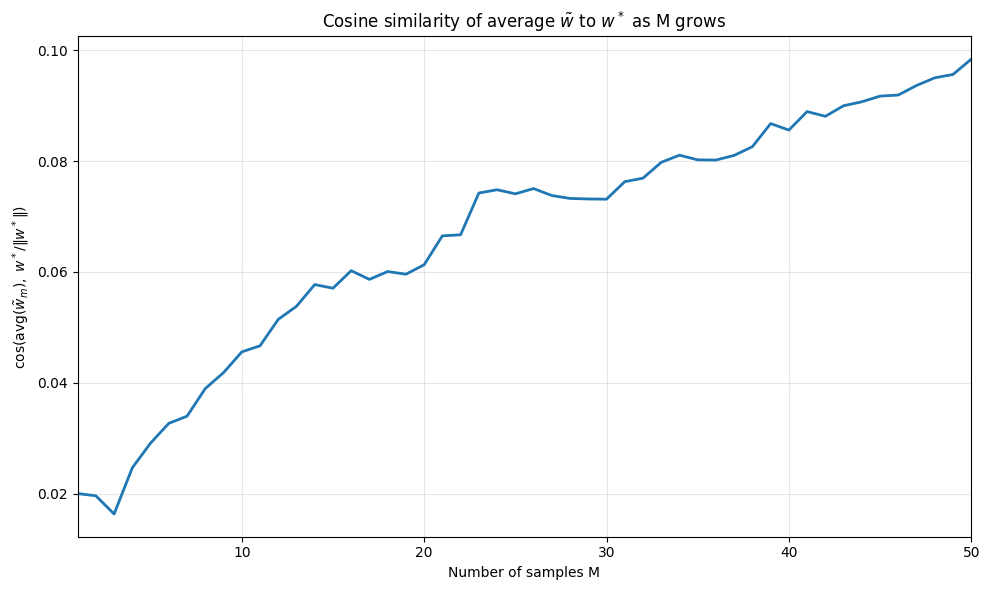

Final cos(avg_wtilde, w*) at M=50: 0.098363


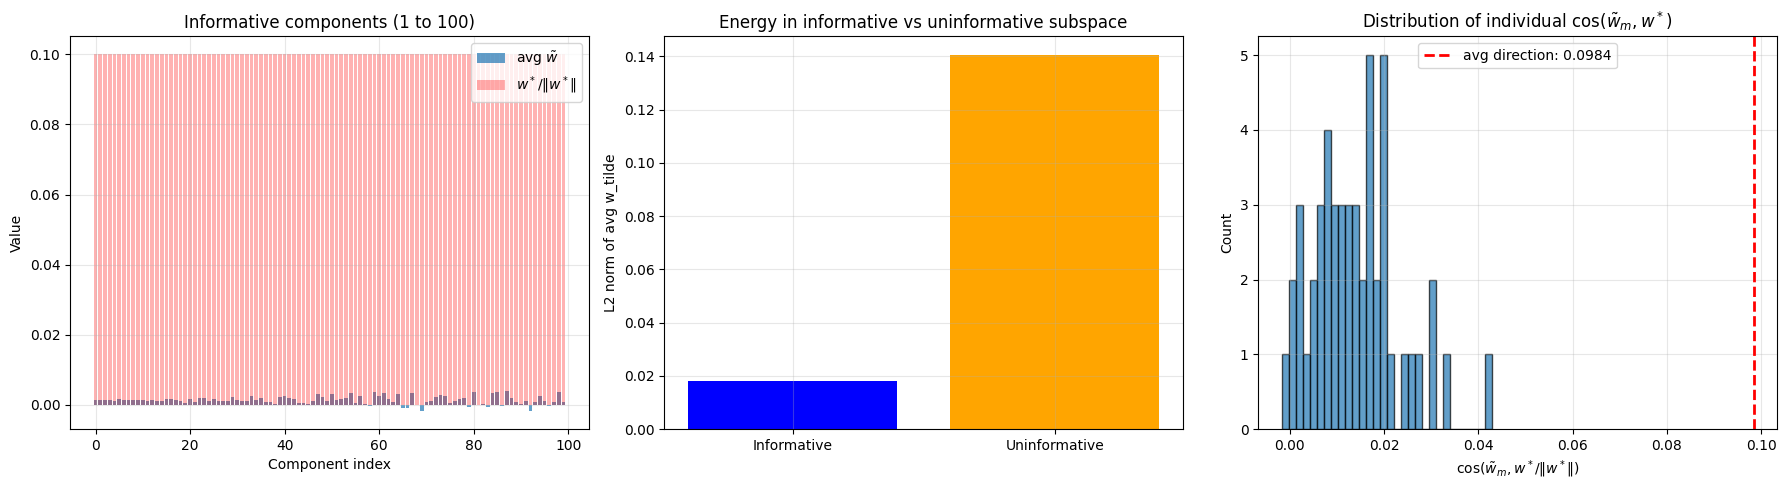

Norm of avg w_tilde in informative subspace: 0.018165
Norm of avg w_tilde in uninformative subspace: 0.140457
Mean individual cos(w_tilde_m, w*): 0.013931
Std individual cos(w_tilde_m, w*): 0.009122


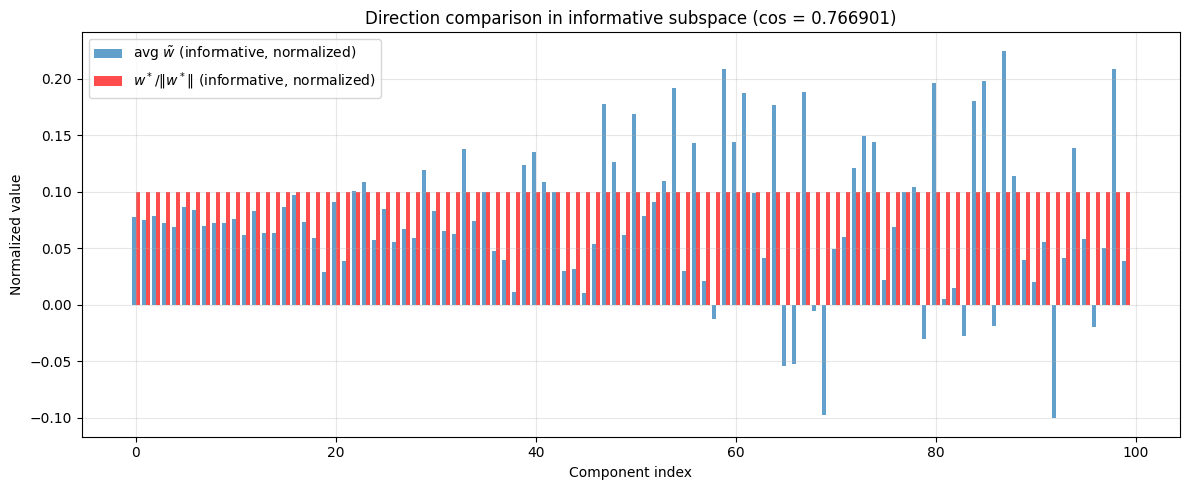

Cosine similarity in informative subspace: 0.766901
-> avg w_tilde does NOT align with w* within informative subspace


In [9]:
plot_convergence_of_average(wtildes, w_star_dir)
plot_component_analysis(wtildes, w_star_dir)
plot_directional_comparison(wtildes, w_star_dir)